In [1]:
# author: tianmin.lv@shanbay.com
# data source: socres_of_classic_story_1123.csv
# paired t-test http://www.statstutor.ac.uk/resources/uploaded/paired-t-test.pdf

In [2]:
# import libraries
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import pandas as pd
import numpy as np
import itertools
import scipy
import csv

In [6]:
# data collection
# from database
'''
SELECT u.book_page_id, u.book_id, u.user_id, u.score, u.fluency, u.pronunciation, u.integrity, u.sentence_elements, b.sentence
FROM user_book_pages u
JOIN book_pages b
ON b.id = u.book_page_id
JOIN books k
ON u.book_id = k.id
JOIN serieses s
ON s.id = k.series_id
WHERE u.sentence_elements != '{}' AND u.score = !0 AND s.title = '100天故事系列'
'''
# from day_number_book_id.csv
'''
SELECT l.book_id,l.day_number
FROM learning_logs l
'''
# from book_title.csv
'''
SELECT b.id, b.title
FROM books b
'''

'\nSELECT b.id, b.title\nFROM books b\n'

In [3]:
# import data
# from database : score_story
# day_number_book_id.csv : day_number_book_id
# book_title.csv : book_title
score_story = pd.read_csv('.../socres_of_classic_story_1123.csv', \
                          encoding='gb2312')
day_number_book_id = pd.read_csv('.../day_number_book_id.csv')
book_title = pd.read_csv('.../book_title.csv')

In [4]:
# first 5 rows of score_story
# book_page_id
# book_id
# user_id
# score: pronunciation * integrity / 100 * 0.97 + fluency * 0.03 from third party
# fluency 
# pronunciation 
# integrity 
# sentence_elements: full version of score details
# sentence: target learning content
score_story.head()

,book_page_id,book_id,user_id,score,fluency,pronunciation,integrity,sentence_elements,sentence
0,336,42,33606,22.7,69.5,20.6,100.0,"{""version"": ""full 1.0"", ""score"": 22.676, ""Eval...",Fly with mom.
1,498,42,33606,72.9,91.6,72.4,100.0,"{""version"": ""full 1.0"", ""score"": 72.942, ""Eval...",I do.
2,499,42,33606,47.9,78.6,46.5,100.0,"{""version"": ""full 1.0"", ""score"": 47.856, ""Eval...",I try.
3,500,42,33606,44.0,76.2,42.6,100.0,"{""version"": ""full 1.0"", ""score"": 44.007, ""Eval...",Fly with me.
4,501,42,33606,41.5,76.0,39.9,100.0,"{""version"": ""full 1.0"", ""score"": 41.454, ""Eval...",I try.


In [7]:
# score_story data overview：9 columns，111536 rows
score_story.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111536 entries, 0 to 111535
Data columns (total 9 columns):
book_page_id         111536 non-null int64
book_id              111536 non-null int64
user_id              111536 non-null int64
score                111536 non-null float64
fluency              111536 non-null float64
pronunciation        111536 non-null float64
integrity            111536 non-null float64
sentence_elements    111536 non-null object
sentence             111536 non-null object
dtypes: float64(4), int64(3), object(2)
memory usage: 7.7+ MB


In [9]:
# story_mean: reader score per book（page mean score）：story_mean
story_mean = score_story.groupby(['book_id','user_id'])['score'].mean().reset_index()

# first five rows of story_mean
story_mean.head()

,book_id,user_id,score
0,42,13,46.428571
1,42,25,16.850000
2,42,56,61.042857
3,42,63,39.728571
4,42,341,49.000000


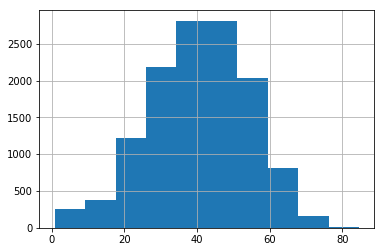

In [10]:
# story_mean distribution：mean around 40
story_mean.score.hist()

In [13]:
# story_mean_day_number： merge story_mean and day_number_book_id on book_id
story_mean_day_number = story_mean.merge(day_number_book_id, how='inner', on='book_id')

# columns of story_mean_day_number
story_mean_day_number.columns

Index(['book_id', 'user_id', 'score', 'id', 'day_number', 'created_at',
       'updated_at', 'term_id'],
      dtype='object')

In [16]:
# remain 'book_id','user_id','score','day_number'
story_mean_day_number = story_mean_day_number[['book_id','user_id','score','day_number']]

# first five rows of story_mean_day_number
story_mean_day_number.head()

,book_id,user_id,score,day_number
0,42,13,46.428571,1
1,42,25,16.850000,1
2,42,56,61.042857,1
3,42,63,39.728571,1
4,42,341,49.000000,1


In [18]:
# first five rows of book_title 
# id： book_id
# title
book_title.head()

,id,title
0,2,The Thirsty Bird
1,3,The Boy Who Cried Wolf
2,4,The Rabbit and the Turtle Race
3,5,The Flies and the Honey
4,6,The Ant and the Cricket


In [19]:
# change column id into book_id 
book_title = book_title.rename(index=str, columns={"id": "book_id"})

In [21]:
# merge story_mean_day_number and book_title；
# form a new dataframe story_score
story_score = story_mean_day_number.merge(book_title, how='inner', on='book_id')

# first five rows of story_score 
story_score.head()

,book_id,user_id,score,day_number,title
0,42,13,46.428571,1,Diligence Makes Up for Lack of Intelligence
1,42,25,16.850000,1,Diligence Makes Up for Lack of Intelligence
2,42,56,61.042857,1,Diligence Makes Up for Lack of Intelligence
3,42,63,39.728571,1,Diligence Makes Up for Lack of Intelligence
4,42,341,49.000000,1,Diligence Makes Up for Lack of Intelligence


In [76]:
# create list: unique_title，include every independent title；
# create list：book_pair，pair each title
# create dictionary：book_pair_compare
unique_title = list(story_score.groupby(['day_number','title']).count().reset_index().title)
book_pair = list(itertools.combinations(unique_title, 2))
book_pair_compare = {}

In [78]:
# iterate book_pair，find all the common users for each single pair，
# paired t-test on book_pair
# abour paied t-test more info：http://www.statstutor.ac.uk/resources/uploaded/paired-t-test.pdf
for pair in book_pair:
    compare_books = story_score.loc[story_score['title'].isin(pair)]
    data_groups = compare_books.groupby(compare_books.user_id)
    size = data_groups.size().reset_index() 
    common_users = list(size[size[0] > 1]['user_id'])
    book_mean_common = story_score.loc[story_score['user_id'].isin(common_users)]
    book_mean_common = book_mean_common.sort_values(by=['title','user_id'])
    book1 = book_mean_common[book_mean_common['title'] == pair[0]]
    book2 = book_mean_common[book_mean_common['title'] == pair[1]]
    v,p = scipy.stats.ttest_rel(book1.score, book2.score)
    book_pair_compare[pair] = v,p

In [79]:
book_mean_common.head()

,book_id,user_id,score,day_number,title
9654,105,1955,1.112500,60,A Boy Who Cried Wolf
9663,105,3299,42.875000,60,A Boy Who Cried Wolf
9667,105,6406,43.650000,60,A Boy Who Cried Wolf
9678,105,18382,7.300000,60,A Boy Who Cried Wolf
9682,105,20292,24.757143,60,A Boy Who Cried Wolf


In [80]:
# create new dataframe: 
# column diff：score difference within each book pair；
# column p_value
# row: two books in a book pair
book_pair_ttest  = pd.DataFrame.from_dict(book_pair_compare, orient='index',columns=['diff', 'p_value'])
book_pair_ttest['diff'] = round(book_pair_ttest['diff'],3)
book_pair_ttest['p_value'] = round(book_pair_ttest['p_value'],3)
# first five rows
book_pair_ttest.head()

,diff,p_value
"(Diligence Makes Up for Lack of Intelligence, One Carrot and Six Kids)",4.296,0.000
"(Diligence Makes Up for Lack of Intelligence, Pull the Chestnuts Out of the Fire)",6.724,0.000
"(Diligence Makes Up for Lack of Intelligence, Mother Cat and Baby Cat Go Fishing)",17.948,0.000
"(Diligence Makes Up for Lack of Intelligence, The Frog and the Ox)",2.554,0.011
"(Diligence Makes Up for Lack of Intelligence, The Dog and the Shadow)",4.344,0.000


In [81]:
# create column book_1 and book_2，from book_pair_ttest
book_1 = []
book_2 = []
for b in list(book_pair_ttest.index):
    book_1.append(b[0])
    book_2.append(b[1])
book_pair_ttest['book_1'] = book_1
book_pair_ttest['book_2'] = book_2
# first five rows
book_pair_ttest.head()

,diff,p_value,book_1,book_2
"(Diligence Makes Up for Lack of Intelligence, One Carrot and Six Kids)",4.296,0.000,Diligence Makes Up for Lack of Intelligence,One Carrot and Six Kids
"(Diligence Makes Up for Lack of Intelligence, Pull the Chestnuts Out of the Fire)",6.724,0.000,Diligence Makes Up for Lack of Intelligence,Pull the Chestnuts Out of the Fire
"(Diligence Makes Up for Lack of Intelligence, Mother Cat and Baby Cat Go Fishing)",17.948,0.000,Diligence Makes Up for Lack of Intelligence,Mother Cat and Baby Cat Go Fishing
"(Diligence Makes Up for Lack of Intelligence, The Frog and the Ox)",2.554,0.011,Diligence Makes Up for Lack of Intelligence,The Frog and the Ox
"(Diligence Makes Up for Lack of Intelligence, The Dog and the Shadow)",4.344,0.000,Diligence Makes Up for Lack of Intelligence,The Dog and the Shadow


In [82]:
days = list(set(list(story_score.day_number)))

In [83]:
# create paried t-test matrix: book_matrix；null values default
book_matrix = pd.DataFrame(np.nan, index=unique_title, columns=unique_title)
# book_matrix first five rows
book_matrix.head()

,Diligence Makes Up for Lack of Intelligence,One Carrot and Six Kids,Pull the Chestnuts Out of the Fire,Mother Cat and Baby Cat Go Fishing,The Frog and the Ox,The Dog and the Shadow,Yu Gong Moves Away the Mountains,Constant Dripping Wears Away a Stone,The Archer and the Suns,Monkeys Scoop Up the Moon,...,Mother Duck Can't Find Her Eggs,Run the Risk,A Fisherman and a Golden Fish (1),A Fisherman and a Golden Fish (2),A Fisherman and a Golden Fish (3),The Rabbit and the Turtle Race,What Is Behind You?,Four Blind Men and the Elephant,Three for Breakfast and Four for Dinner,Where Is My Mama?
Diligence Makes Up for Lack of Intelligence,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
One Carrot and Six Kids,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Pull the Chestnuts Out of the Fire,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Mother Cat and Baby Cat Go Fishing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
The Frog and the Ox,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [84]:
# put diff value from book_pair_ttest into book_matrix
for b in range(len(book_pair_ttest['book_1'])):
    book_matrix.loc[book_pair_ttest['book_1'][b],book_pair_ttest['book_2'][b]] = float(book_pair_ttest.loc[book_pair_ttest.index == \
                                                                                                           (book_pair_ttest['book_1'][b],book_pair_ttest['book_2'][b])]['diff'][0])
# book_matrix前10行
book_matrix.head(10)

,Diligence Makes Up for Lack of Intelligence,One Carrot and Six Kids,Pull the Chestnuts Out of the Fire,Mother Cat and Baby Cat Go Fishing,The Frog and the Ox,The Dog and the Shadow,Yu Gong Moves Away the Mountains,Constant Dripping Wears Away a Stone,The Archer and the Suns,Monkeys Scoop Up the Moon,...,Mother Duck Can't Find Her Eggs,Run the Risk,A Fisherman and a Golden Fish (1),A Fisherman and a Golden Fish (2),A Fisherman and a Golden Fish (3),The Rabbit and the Turtle Race,What Is Behind You?,Four Blind Men and the Elephant,Three for Breakfast and Four for Dinner,Where Is My Mama?
Diligence Makes Up for Lack of Intelligence,NaN,4.296,6.724,17.948,2.554,4.344,6.580,10.906,28.380,0.826,...,3.917,3.814,2.563,2.691,3.275,6.536,4.926,7.547,3.755,-3.221
One Carrot and Six Kids,NaN,NaN,3.239,15.461,-1.170,1.820,3.170,6.393,27.448,-2.252,...,2.242,1.687,0.615,0.917,1.859,4.046,2.871,6.849,2.506,-3.567
Pull the Chestnuts Out of the Fire,NaN,NaN,NaN,11.041,-5.141,-1.470,-0.195,2.668,20.686,-4.312,...,0.226,0.059,-0.673,0.719,2.273,3.308,3.120,5.689,3.085,-4.817
Mother Cat and Baby Cat Go Fishing,NaN,NaN,NaN,NaN,-16.968,-13.598,-9.488,-7.119,12.755,-13.572,...,-5.078,-7.430,-8.488,-5.614,-2.609,-0.670,-1.489,-0.088,-0.940,-12.164
The Frog and the Ox,NaN,NaN,NaN,NaN,NaN,2.738,5.477,6.331,26.638,0.026,...,3.066,2.014,2.439,2.355,2.994,4.762,3.931,7.496,4.712,-3.308
The Dog and the Shadow,NaN,NaN,NaN,NaN,NaN,NaN,2.824,6.842,29.058,-2.059,...,-0.129,-0.185,-0.669,0.959,1.572,3.912,2.189,6.357,4.117,-6.910
Yu Gong Moves Away the Mountains,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.302,22.411,-3.377,...,-0.189,-1.083,-1.285,0.255,1.173,2.267,1.317,5.266,2.365,-4.598
Constant Dripping Wears Away a Stone,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.743,-6.318,...,-1.220,-3.103,-2.131,-1.347,-0.051,1.558,0.816,2.770,0.125,-10.208
The Archer and the Suns,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-25.716,...,-13.184,-13.683,-14.322,-8.935,-7.223,-4.568,-5.893,-4.825,-6.460,-16.470
Monkeys Scoop Up the Moon,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.806,1.294,1.023,1.465,2.595,5.464,3.595,6.026,4.254,-4.972


In [86]:
# 2556 values in total, bingo!
72**2 - book_matrix.isna().sum().sum()

2556

In [97]:
# create book_matrix_pvalue，input p value
book_matrix_pvalue = pd.DataFrame(np.nan, index=unique_title, columns=unique_title)
for b in range(len(book_pair_ttest['book_1'])):
    book_matrix_pvalue.loc[book_pair_ttest['book_1'][b],book_pair_ttest['book_2'][b]] = float(book_pair_ttest.loc[book_pair_ttest.index == \
                                                                                                                  (book_pair_ttest['book_1'][b],book_pair_ttest['book_2'][b])]['p_value'][0])
# book_matrix first ten rows
book_matrix_pvalue.head(10)

# book_matrix last ten rows
book_matrix_pvalue.tail(10)


,Diligence Makes Up for Lack of Intelligence,One Carrot and Six Kids,Pull the Chestnuts Out of the Fire,Mother Cat and Baby Cat Go Fishing,The Frog and the Ox,The Dog and the Shadow,Yu Gong Moves Away the Mountains,Constant Dripping Wears Away a Stone,The Archer and the Suns,Monkeys Scoop Up the Moon,...,Mother Duck Can't Find Her Eggs,Run the Risk,A Fisherman and a Golden Fish (1),A Fisherman and a Golden Fish (2),A Fisherman and a Golden Fish (3),The Rabbit and the Turtle Race,What Is Behind You?,Four Blind Men and the Elephant,Three for Breakfast and Four for Dinner,Where Is My Mama?
Mother Duck Can't Find Her Eggs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.832,0.388,0.926,0.161,0.001,0.029,0.00,0.001,0.000
Run the Risk,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.865,0.090,0.144,0.000,0.013,0.00,0.000,0.000
A Fisherman and a Golden Fish (1),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.101,0.006,0.000,0.001,0.00,0.000,0.000
A Fisherman and a Golden Fish (2),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.170,0.000,0.003,0.00,0.000,0.000
A Fisherman and a Golden Fish (3),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.010,0.064,0.00,0.077,0.001
The Rabbit and the Turtle Race,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.243,0.02,0.444,0.000
What Is Behind You?,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.060,0.000
Four Blind Men and the Elephant,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003,0.000
Three for Breakfast and Four for Dinner,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000
Where Is My Mama?,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


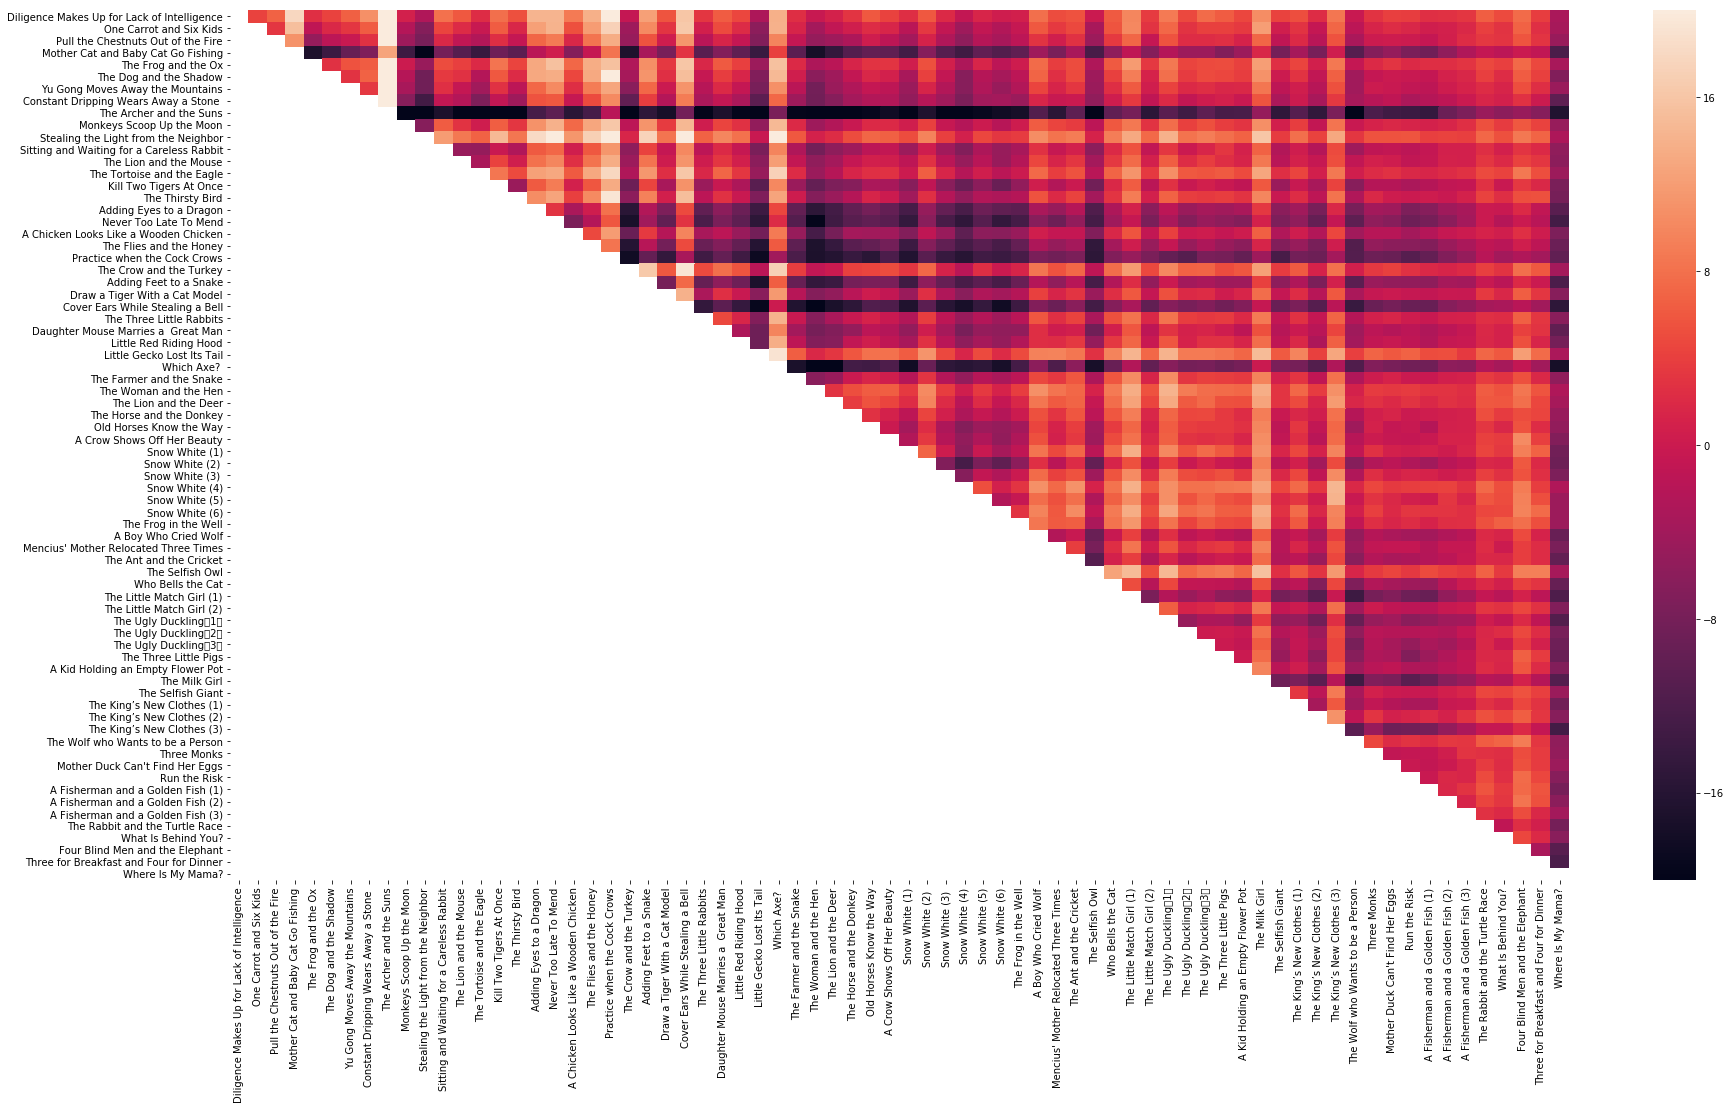

In [98]:
# make a chart on book_matrix
plt.figure(figsize=(30,16))
axs1 = sns.heatmap(book_matrix, annot=False, vmin = -20, vmax = 20)
fig1 = axs1.get_figure()
fig1.savefig("Paired_t_tests_score_difference.png")

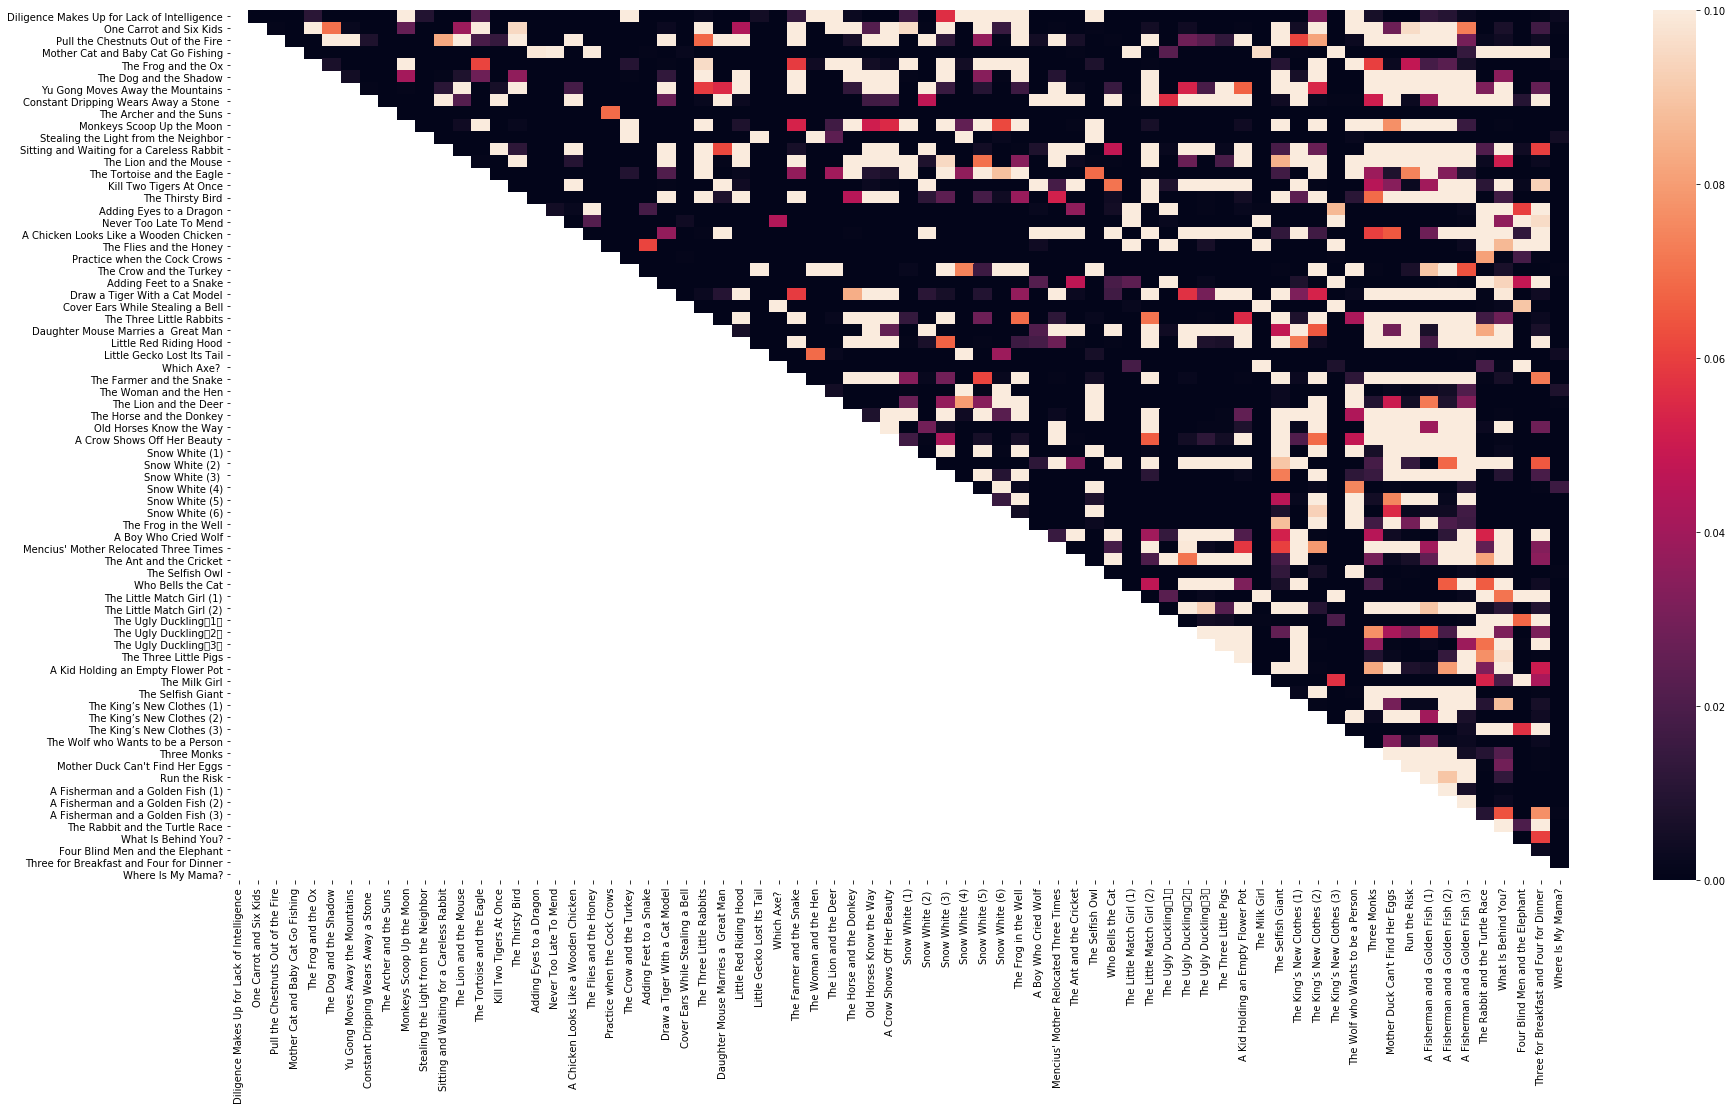

In [91]:
# make a chart on book_matrix_pvalue
plt.figure(figsize=(30,16))
axs2 = sns.heatmap(book_matrix_pvalue, annot=False , vmax=0.1)
fig2 = axs2.get_figure()
fig2.savefig("Paired_t_tests_p_value.png")